<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/practice_notebooks/Intel_images_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle tensorflow==2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uni

In [2]:
import tensorflow as tf

tf.__version__

'2.9.0'

In [3]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:16<00:00, 25.5MB/s]
100% 346M/346M [00:16<00:00, 22.3MB/s]


In [5]:
! unzip intel-image-classification.zip -d intel_dataset

Streaming output truncated to the last 5000 lines.
  inflating: intel_dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_dataset/seg_train/seg_train/mountain/767.jpg  
  inflating:

In [6]:
TRAIN_DIR = "/content/intel_dataset/seg_train/seg_train"
VAL_DIR =  "/content/intel_dataset/seg_test/seg_test"
PRED_DIR = "/content/intel_dataset/seg_pred/seg_pred"

In [7]:
import os
class_names = sorted(os.listdir(TRAIN_DIR))
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
import os
import shutil
import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from sklearn.model_selection import train_test_split
import cv2

import warnings
warnings.filterwarnings('ignore')

In [9]:
def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

tf.random.set_seed(99)

## Initalize Image Data Generator with Augmentation
train_img_data_generator = ImageDataGenerator(rescale=1/255,
                                              validation_split=0.2,
                                              rotation_range = 180,
                                              horizontal_flip = True,
                                              vertical_flip = True,
                                              preprocessing_function=blur_preprocessing)

val_image_data_generator = ImageDataGenerator(rescale = 1/255, 
                                              validation_split=0.2,
                                              rotation_range = 180,
                                              horizontal_flip = True,
                                              vertical_flip = True,
                                              preprocessing_function=blur_preprocessing)

## Recreate datasets from dataframe
train_data_multi = train_img_data_generator.flow_from_directory(TRAIN_DIR,
                                                    target_size=(150, 150),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=42)

val_data_multi = val_image_data_generator.flow_from_directory(VAL_DIR,
                                                    target_size=(150, 150),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=42)

Found 11230 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


In [10]:
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [11]:
CLASSES = len(class_names)
IMG_SHAPE = 150

In [12]:
# learning rate decay
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        self.patience = 5
        self.best = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if np.greater(logs["val_accuracy"], self.best):
            self.wait = 0
            self.best = logs["val_accuracy"]
        else:
            self.wait +=1
            if self.wait >= self.patience:
                print(f"Stopping Training. Validation accuracy hasn't improved >= {self.patience} times")
                self.model.stop_training=True

In [13]:
def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f"saved_models/intel_images_dataset/{model_name}.h5",monitor='val_loss', save_best_only='True', verbose=1)
  ES = EarlyStoppingCallback()
  return [MC, ES]

In [14]:
model_configs = dict()

def cfg_model_run(model, history):
    return {"model": model, "history" : history}

In [24]:
def run_model(model_name, model_func, model_configs, epochs, classes):

    model = model_func(classes, trainable_weights = False)

    model_hist = model.fit(train_data_multi, validation_data=val_data_multi, epochs=epochs, callbacks= get_callbacks(model.name))
    model_configs[model_name] = cfg_model_run(model, model_hist)
    return

In [16]:
def create_base_model(classes, trainable_weights = False, weights_path=None):
  tf.keras.backend.clear_session()
  model = tf.keras.Sequential(name="Base_Model")
  model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.24))
  model.add(tf.keras.layers.Dense(classes,activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
  return model

In [17]:
def create_densenet_model(classes, trainable_weights=False, weights_path=None):
    tf.keras.backend.clear_session()
    dense_net = DenseNet201(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), weights="imagenet", include_top=False)
    for layer in dense_net.layers:
        layer.trainable=trainable_weights
    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(classes, activation='softmax')
                                ], name="densenet201")
    if weights_path:
        model.load_weights(weights_path)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16

def create_vgg16_model(classes, trainable_weights=False, weights_path=None):
    tf.keras.backend.clear_session()
    vgg16 = VGG16(input_shape = (IMG_SHAPE, IMG_SHAPE, 3), include_top = False, weights = 'imagenet')
    for layer in vgg16.layers:
      layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential(name="vgg16")
    # initialize EfficientNetB3 model with input shape as (300,300,3)
    model.add(vgg16)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax'))
    if weights_path:
        model.load_weights(weights_path)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_inception_model(classes, trainable_weights=False, weights_path=None):
    tf.keras.backend.clear_session()
    inception = InceptionV3(input_shape = (IMG_SHAPE, IMG_SHAPE, 3), include_top = False, weights = 'imagenet')
    for layer in inception.layers:
      layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential(name="inception")
    # initialize EfficientNetB3 model with input shape as (300,300,3)
    model.add(inception)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax'))
    if weights_path:
        model.load_weights(weights_path)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [20]:
from tensorflow.keras.applications import ResNet50

def create_resnet_model(classes, trainable_weights=False, weights_path=None):
    tf.keras.backend.clear_session()
    resnet = ResNet50(input_shape = (IMG_SHAPE, IMG_SHAPE, 3), include_top = False, weights = 'imagenet')
    for layer in resnet.layers:
      layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential(name="resnet")
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax'))
    if weights_path:
        model.load_weights(weights_path)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [21]:
from tensorflow.keras.applications import EfficientNetB7

def create_efficientnet_model(classes, trainable_weights=False, weights_path=None):
    tf.keras.backend.clear_session()
    efficientnet = EfficientNetB7(input_shape = (IMG_SHAPE, IMG_SHAPE, 3), include_top = False, weights = 'imagenet')
    for layer in efficientnet.layers:
      layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential(name="efficientnet")
    
    model.add(efficientnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax'))
    if weights_path:
        model.load_weights(weights_path)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [22]:
from tensorflow.keras.applications import MobileNetV2

def create_mobilenet_model(classes, trainable_weights=False, weights_path=None):
    tf.keras.backend.clear_session()
    resnet = MobileNetV2(input_shape = (IMG_SHAPE, IMG_SHAPE, 3), include_top = False, weights = 'imagenet')
    for layer in resnet.layers:
      layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential(name="mobilenetv2")
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax'))
    if weights_path:
        model.load_weights(weights_path)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [25]:
model_configs=dict()
run_model("Base_model", create_base_model, model_configs, epochs=25, classes = CLASSES)
run_model("EfficientNet", create_efficientnet_model, model_configs, epochs=25, classes = CLASSES)
run_model("Densenet", create_densenet_model, model_configs, epochs=25, classes = CLASSES)
run_model("MobileNetV2", create_mobilenet_model, model_configs, epochs=25, classes = CLASSES)
run_model("VGG16", create_vgg16_model, model_configs, epochs=25, classes = CLASSES)
run_model("Inception", create_inception_model, model_configs, epochs=25, classes = CLASSES)
run_model("ResNet50", create_resnet_model, model_configs, epochs=25, classes = CLASSES)

Epoch 1/25
351/351 [==============================] - ETA: 0s - loss: 1.4922 - accuracy: 0.3637
Epoch 1: val_loss improved from inf to 1.39214, saving model to saved_models/intel_images_dataset/Base_Model.h5
351/351 [==============================] - 76s 216ms/step - loss: 1.4922 - accuracy: 0.3637 - val_loss: 1.3921 - val_accuracy: 0.4331
Epoch 2/25
351/351 [==============================] - ETA: 0s - loss: 1.4318 - accuracy: 0.3907
Epoch 2: val_loss improved from 1.39214 to 1.38863, saving model to saved_models/intel_images_dataset/Base_Model.h5
351/351 [==============================] - 75s 214ms/step - loss: 1.4318 - accuracy: 0.3907 - val_loss: 1.3886 - val_accuracy: 0.4281
Epoch 3/25
351/351 [==============================] - ETA: 0s - loss: 1.4348 - accuracy: 0.3889
Epoch 3: val_loss did not improve from 1.38863
351/351 [==============================] - 75s 212ms/step - loss: 1.4348 - accuracy: 0.3889 - val_loss: 1.3893 - val_accuracy: 0.4398
Epoch 4/25
351/351 [===============

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/25
351/351 [==============================] - ETA: 0s - loss: 1.0859 - accuracy: 0.5819
Epoch 1: val_loss improved from inf to 0.89839, saving model to saved_models/intel_images_dataset/mobilenetv2.h5
351/351 [==============================] - 80s 219ms/step - loss: 1.0859 - accuracy: 0.5819 - val_loss: 0.8984 - val_accuracy: 0.6538
Epoch 2/25
351/351 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.6286
Epoch 2: val_loss did not improve from 0.89839
351/351 [==============================] - 75s 213ms/step - loss: 0.9656 - accuracy: 0.6286 - val_loss: 0.9005 - val_accuracy: 0.6839
Epoch 3/25
351/351 [==============================] - ETA: 0s - loss: 0.9655 - accuracy: 0.6246
Epoch 3: val_loss improved from 0.89839 to 0.85447, saving model to saved_models/intel_images_dataset/mobilenetv2.h5
351/351 [==============================] - 75s 215ms/step - loss: 0.9655 - accuracy: 0.6246 - val_loss: 

In [26]:
import math
number_of_examples = len(val_data_multi.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(val_data_multi[i][1]))

In [27]:
y_true = tf.argmax(test_labels, axis=1)

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
models_results = {}
for key, val in model_configs.items():
  preds = val['model'].predict(val_data_multi)
  y_pred = tf.argmax(preds, axis=1)
  models_results[key] = calculate_results(y_true, y_pred)

19/19 [==============================] - 8s 309ms/step


In [32]:
model_results_df  = pd.DataFrame(models_results).T
model_results_df

,accuracy,precision,recall,f1
Base_model,43.143813,0.413584,0.431438,0.384086
EfficientNet,17.558528,0.030830,0.175585,0.052451
Densenet,20.066890,0.192595,0.200669,0.195527
MobileNetV2,15.886288,0.157308,0.158863,0.157760
VGG16,16.889632,0.179742,0.168896,0.171126
Inception,18.060201,0.179127,0.180602,0.179183
ResNet50,16.387960,0.083296,0.163880,0.093288


In [33]:
y_labels = []
for images, labels in val_data_multi.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

AttributeError: ignored

In [34]:
IMG_SIZE = (150, 150)
train_data_new = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, label_mode="categorical",image_size=IMG_SIZE)
                                                                                
test_data_new = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR, label_mode="categorical", image_size=IMG_SIZE, shuffle=False)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [37]:
def run_model(model_name, model_func, model_configs, epochs, classes):

    model = model_func(classes, trainable_weights = False)

    model_hist = model.fit(train_data_new, validation_data=test_data_new, epochs=epochs, callbacks= get_callbacks(model.name))
    model_configs[model_name] = cfg_model_run(model, model_hist)
    return

In [38]:
model_configs=dict()
run_model("Base_model", create_base_model, model_configs, epochs=25, classes = CLASSES)
run_model("EfficientNet", create_efficientnet_model, model_configs, epochs=25, classes = CLASSES)
run_model("Densenet", create_densenet_model, model_configs, epochs=25, classes = CLASSES)

Epoch 1/25
439/439 [==============================] - ETA: 0s - loss: 2.0193 - accuracy: 0.3583
Epoch 1: val_loss improved from inf to 1.48136, saving model to saved_models/intel_images_dataset/Base_Model.h5
439/439 [==============================] - 14s 29ms/step - loss: 2.0193 - accuracy: 0.3583 - val_loss: 1.4814 - val_accuracy: 0.4180
Epoch 2/25
438/439 [============================>.] - ETA: 0s - loss: 1.5061 - accuracy: 0.3975
Epoch 2: val_loss improved from 1.48136 to 1.48056, saving model to saved_models/intel_images_dataset/Base_Model.h5
439/439 [==============================] - 13s 30ms/step - loss: 1.5064 - accuracy: 0.3972 - val_loss: 1.4806 - val_accuracy: 0.4160
Epoch 3/25
437/439 [============================>.] - ETA: 0s - loss: 1.5063 - accuracy: 0.3986
Epoch 3: val_loss did not improve from 1.48056
439/439 [==============================] - 13s 30ms/step - loss: 1.5065 - accuracy: 0.3983 - val_loss: 1.4806 - val_accuracy: 0.4160
Epoch 4/25
439/439 [==================

In [42]:
y_labels = []
for images, labels in test_data_new.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]
len(y_labels) # check what they look like (unshuffled)

3000

94/94 [==============================] - 7s 77ms/step


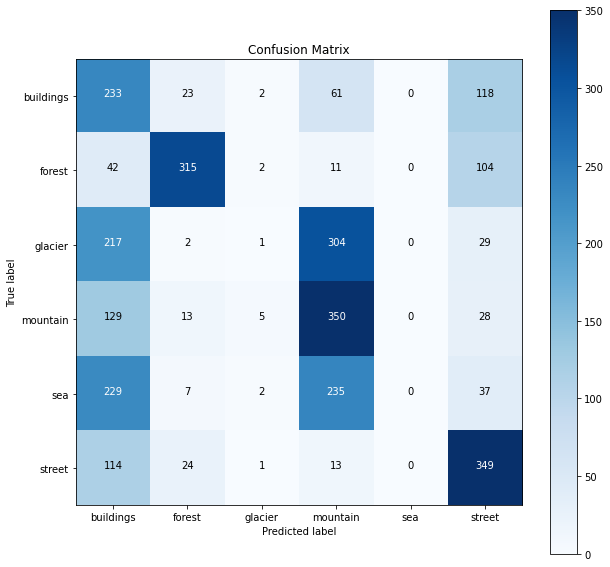

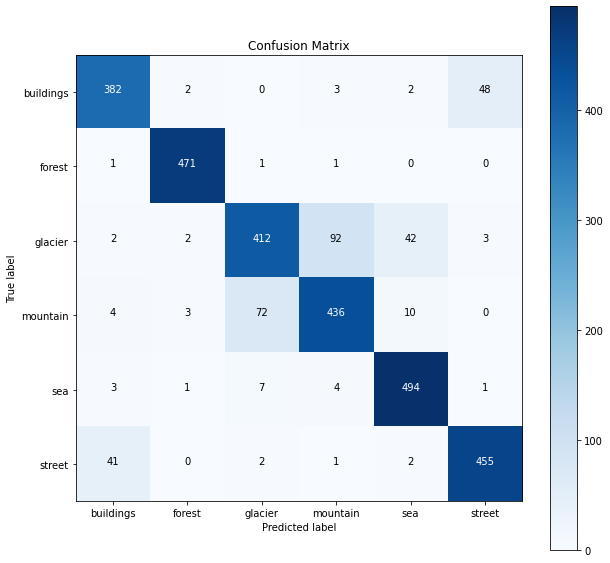

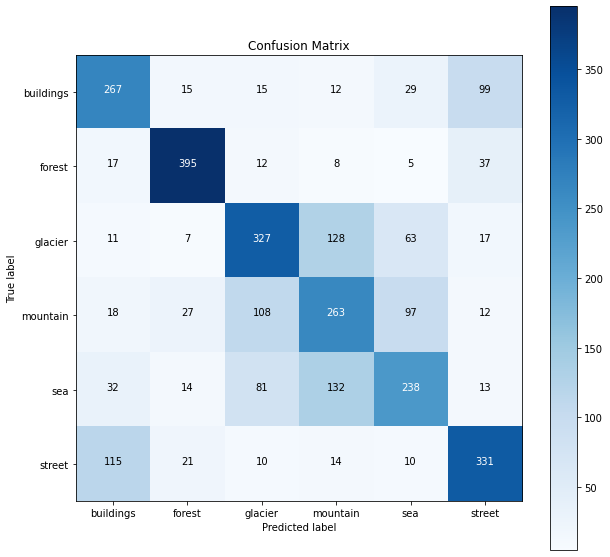

In [50]:
count = 10
models_results = {}
for key, val in model_configs.items():
  preds = val['model'].predict(test_data_new)
  y_pred = tf.argmax(preds, axis=1)
  models_results[key] = calculate_results(y_labels, y_pred)
  count = count+1
  make_confusion_matrix(y_labels, y_pred, f"/content/saved_models/{count}.png", class_names, figsize=(10, 10), text_size=10, savefig = True)

In [44]:
model_results_df  = pd.DataFrame(models_results).T
model_results_df

,accuracy,precision,recall,f1
Base_model,41.600000,0.329525,0.416000,0.346809
EfficientNet,88.333333,0.882255,0.883333,0.882075
Densenet,60.700000,0.606610,0.607000,0.606227


In [45]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, filename, classes=None, figsize=(10, 10), text_size=15, norm=False,  savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig(filename)

94/94 [==============================] - 2s 18ms/step
{'accuracy': 41.6, 'precision': 0.32952529613011816, 'recall': 0.416, 'f1': 0.3468089106638165}
94/94 [==============================] - 7s 64ms/step
{'accuracy': 17.833333333333336, 'precision': 0.21470465182818618, 'recall': 0.17833333333333334, 'f1': 0.12882364546863445}
94/94 [==============================] - 12s 83ms/step
{'accuracy': 60.699999999999996, 'precision': 0.6066101128378496, 'recall': 0.607, 'f1': 0.6062271574992656}
94/94 [==============================] - 6s 51ms/step
{'accuracy': 6.966666666666667, 'precision': 0.1411181970143636, 'recall': 0.06966666666666667, 'f1': 0.05470726331313614}
94/94 [==============================] - 24s 190ms/step
{'accuracy': 88.33333333333333, 'precision': 0.8822546495094319, 'recall': 0.8833333333333333, 'f1': 0.8820751971920174}
94/94 [==============================] - 3s 28ms/step
{'accuracy': 18.099999999999998, 'precision': 0.22363152073155823, 'recall': 0.181, 'f1': 0.0909815

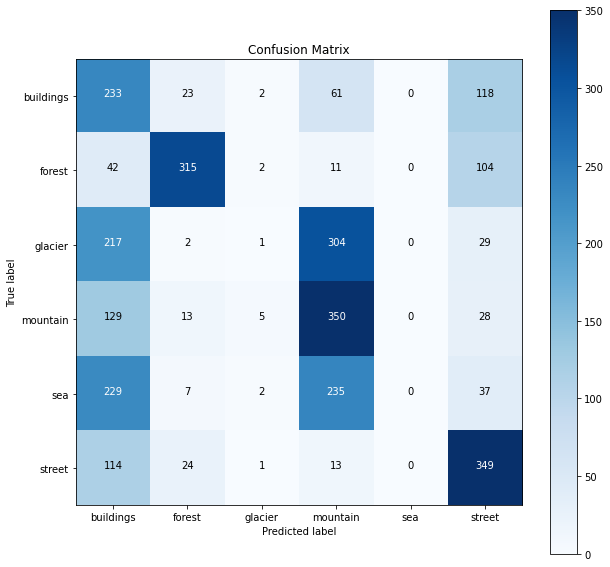

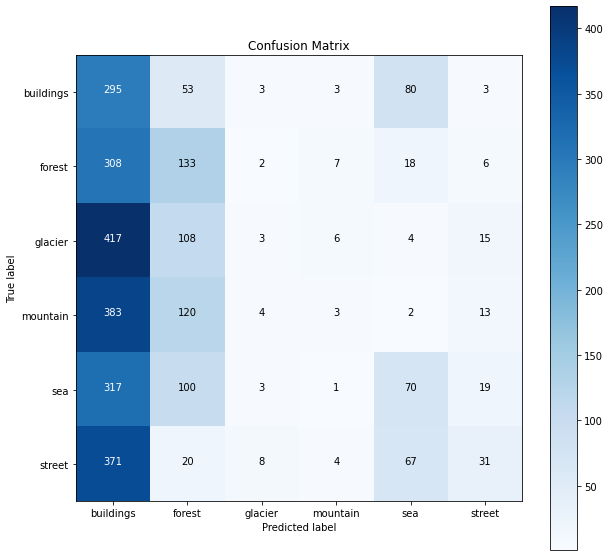

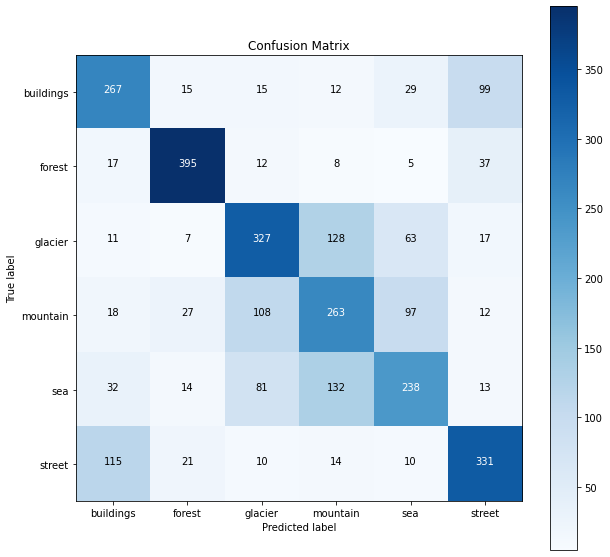

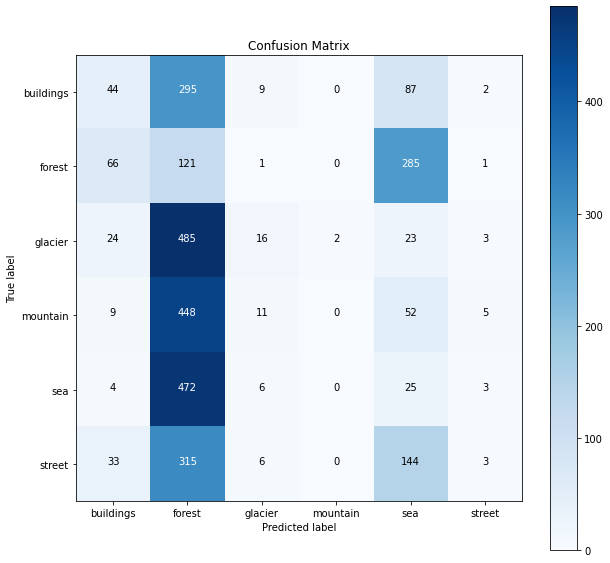

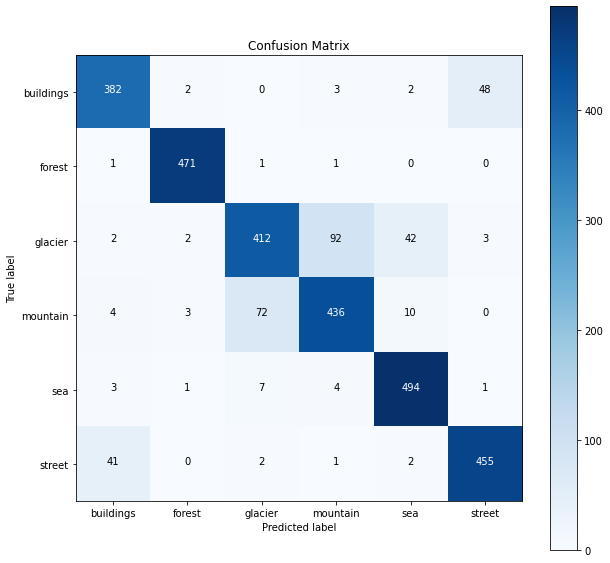

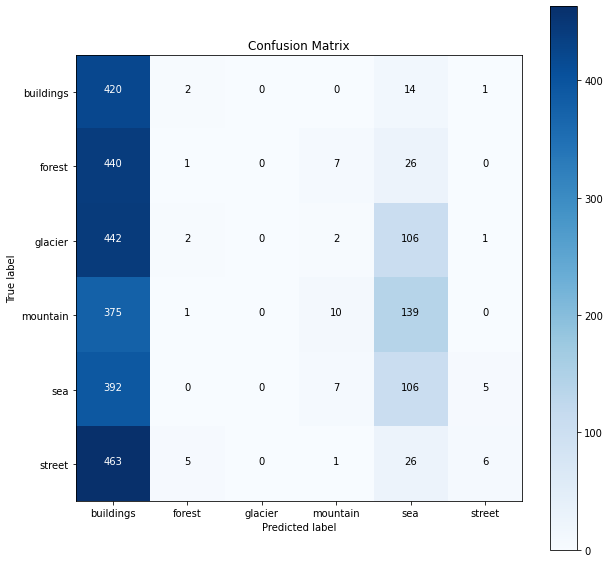

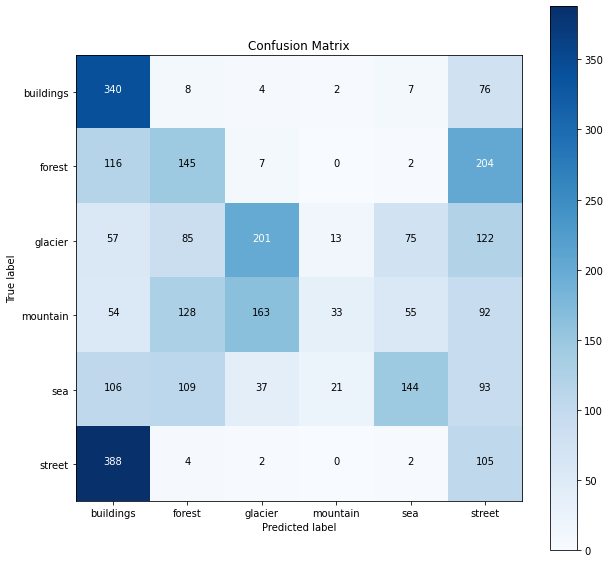

In [48]:
classes = ['rock', 'paper', 'scissors']
count = 0
for file in os.listdir("/content/saved_models/intel_images_dataset"):
  new_model=tf.keras.models.load_model(f"/content/saved_models/intel_images_dataset/{file}")
  res = new_model.predict(test_data_new)
  res = tf.argmax(res, axis=1)
  print(calculate_results(y_labels, res))
  count = count + 1
  make_confusion_matrix(y_labels, res, f"/content/saved_models/{count}.png", class_names, figsize=(10, 10), text_size=10, savefig = True)